### PyStok 33, 25.09.2018

https://www.kaggle.com/miodeq/

http://maciekj.pl/

https://www.linkedin.com/pulse/hcc-survival-prediction-using-supervised-ml-maciej-januszewski/

### Survival prediction with Logistic Regression and DecisionTreeClassifier

### ABOUT HCC DATASET

**HCC** dataset was obtained at a University Hospital in Portugal and contais several demographic, risk factors, laboratory and overall survival features of 165 real patients diagnosed with HCC. 

The dataset contains 49 features selected according to the EASL-EORTC (European Association for the Study of the Liver - European Organisation for Research and Treatment of Cancer) Clinical Practice Guidelines, which are the current state-of-the-art on the management of HCC.

This is an heterogeneous dataset, with 23 quantitative variables, and 26 qualitative variables. Overall, missing data represents 10.22% of the whole dataset and only eight patients have complete information in all fields (4.85%). 

The target variables is the survival at 1 year, and was encoded as a binary variable: 0 (die) and 1 (lives). A certain degree of class-imbalance is also present (63 cases labeled as “dies” and 102 as “lives”).

In [1]:
import operator
from fancyimpute import KNN 
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.feature_selection import RFECV
from operator import itemgetter 
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, classification_report, r2_score, make_scorer, roc_curve, auc
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, StratifiedKFold, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression

%matplotlib inline

plt.style.use('bmh')

Using TensorFlow backend.
/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### EDA

Dataset doesn't contain column names. To understand better data, I put columns.

In [2]:
columns = [
    # nominal
    'gender', #0-1
    'symptoms', #0-1
    'alcohol', #0-1
    'hepatitis b surface antigen', #0-1
    'hepatitis b e antigen', #0-1
    'hepatitis b core antibody', #0-1
    'hepatitis c virus antibody', #0-1
    'cirrhosis', #0-1
    'endemic countries', #0-1
    'smoking', #0-1
    'diabetes', #0-1
    'obesity', #0-1
    'hemochromatosis', #0-1
    'arterial hypertension', #0-1
    'chronic renal insufficiency', #0-1
    'human immunodeficiency virus', #0-1
    'nonalcoholic steatohepatitis', #0-1
    'esophageal varices', #0-1
    'splenomegaly', #0-1
    'portal hypertension', #0-1
    'portal vein thrombosis', #0-1
    'liver metastasis', #0-1
    'radiological hallmark', #0-1
    
    # integer
    'age', # age at diagnosis
    
    # continuous
    'grams of alcohol per day',
    'packs of cigarets per year',
    
    # ordinal
    'performance status',
    'encephalopathy degree',
    'ascites degree',
     
    # continuous   
    'international normalised ratio',
    'alpha-fetoprotein',
    'haemoglobin',
    'mean corpuscular volume',
    'leukocytes',
    'platelets',
    'albumin',
    'total bilirubin',
    'alanine transaminase',
    'aspartate transaminase',
    'gamma glutamyl transferase',
    'alkaline phosphatase',
    'total proteins',
    'creatinine',
    
    # integer
    'number of nodules',
    
    # continuous
    'major dimension of nodule cm',
    'direct bilirubin mg/dL',
    'iron',
    'oxygen saturation %',
    'ferritin',
        
    #nominal
    'class attribute', #0-1
]

columns = list([x.replace(' ', '_').strip() for x in columns])

In [3]:
df = pd.read_csv(
    './hcc-data.csv', 
    names=columns, 
    header=None, 
    na_values=['?']
)

In [4]:
data = df.copy()

### EDA

In [5]:
data.head()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,...,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,...,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
gender                            165 non-null int64
symptoms                          147 non-null float64
alcohol                           165 non-null int64
hepatitis_b_surface_antigen       148 non-null float64
hepatitis_b_e_antigen             126 non-null float64
hepatitis_b_core_antibody         141 non-null float64
hepatitis_c_virus_antibody        156 non-null float64
cirrhosis                         165 non-null int64
endemic_countries                 126 non-null float64
smoking                           124 non-null float64
diabetes                          162 non-null float64
obesity                           155 non-null float64
hemochromatosis                   142 non-null float64
arterial_hypertension             162 non-null float64
chronic_renal_insufficiency       163 non-null float64
human_immunodeficiency_virus      151 non-null float64
nonalcoholic_steatohe

In [7]:
data.isnull().sum(axis=0)

gender                             0
symptoms                          18
alcohol                            0
hepatitis_b_surface_antigen       17
hepatitis_b_e_antigen             39
hepatitis_b_core_antibody         24
hepatitis_c_virus_antibody         9
cirrhosis                          0
endemic_countries                 39
smoking                           41
diabetes                           3
obesity                           10
hemochromatosis                   23
arterial_hypertension              3
chronic_renal_insufficiency        2
human_immunodeficiency_virus      14
nonalcoholic_steatohepatitis      22
esophageal_varices                52
splenomegaly                      15
portal_hypertension               11
portal_vein_thrombosis             3
liver_metastasis                   4
radiological_hallmark              2
age                                0
grams_of_alcohol_per_day          48
packs_of_cigarets_per_year        53
performance_status                 0
e

In [8]:
data.describe()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,...,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute
count,165.000000,147.000000,165.000000,148.000000,126.000000,141.000000,156.000000,165.000000,126.000000,124.000000,...,162.000000,154.000000,158.000000,163.000000,145.000000,121.000000,86.000000,85.000000,85.000000,165.000000
mean,0.806061,0.639456,0.739394,0.108108,0.007937,0.269504,0.217949,0.903030,0.079365,0.508065,...,212.211605,8.961039,1.127089,2.736196,6.851172,1.930000,85.598837,37.028941,438.997647,0.618182
std,0.396586,0.481800,0.440302,0.311571,0.089087,0.445284,0.414182,0.296817,0.271387,0.501963,...,167.943548,11.728739,0.955856,1.797901,5.095042,4.210452,55.698995,28.993552,457.114454,0.487311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.280000,3.900000,0.200000,0.000000,1.500000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,108.250000,6.300000,0.700000,1.000000,3.000000,0.370000,40.500000,16.000000,84.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,162.000000,7.050000,0.850000,2.000000,5.000000,0.700000,83.000000,27.000000,295.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,261.500000,7.575000,1.100000,5.000000,9.000000,1.400000,118.000000,56.000000,706.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,980.000000,102.000000,7.600000,5.000000,22.000000,29.300000,224.000000,126.000000,2230.000000,1.000000


#### What do we know about patients ?

In [9]:
data['age'].isnull().sum()

0

In [10]:
print('The oldest patient: {} years.'.format(data['age'].max()))
print('The youngest patient: {} years.'.format(data['age'].min()))
print('Average age: {} years.'.format(data['age'].mean()))
print('Median age: {} years.'.format(data['age'].median(skipna=True)))

The oldest patient: 93 years.
The youngest patient: 20 years.
Average age: 64.69090909090909 years.
Median age: 66.0 years.


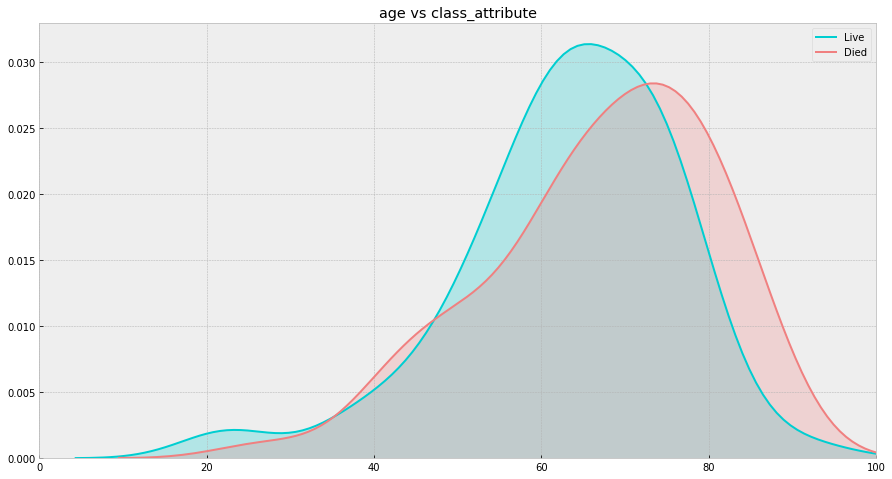

In [11]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data.age[data.class_attribute == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data.age[data.class_attribute == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['Live', 'Died'])
plt.title('age vs class_attribute')
plt.xlim(0,100)
plt.show()

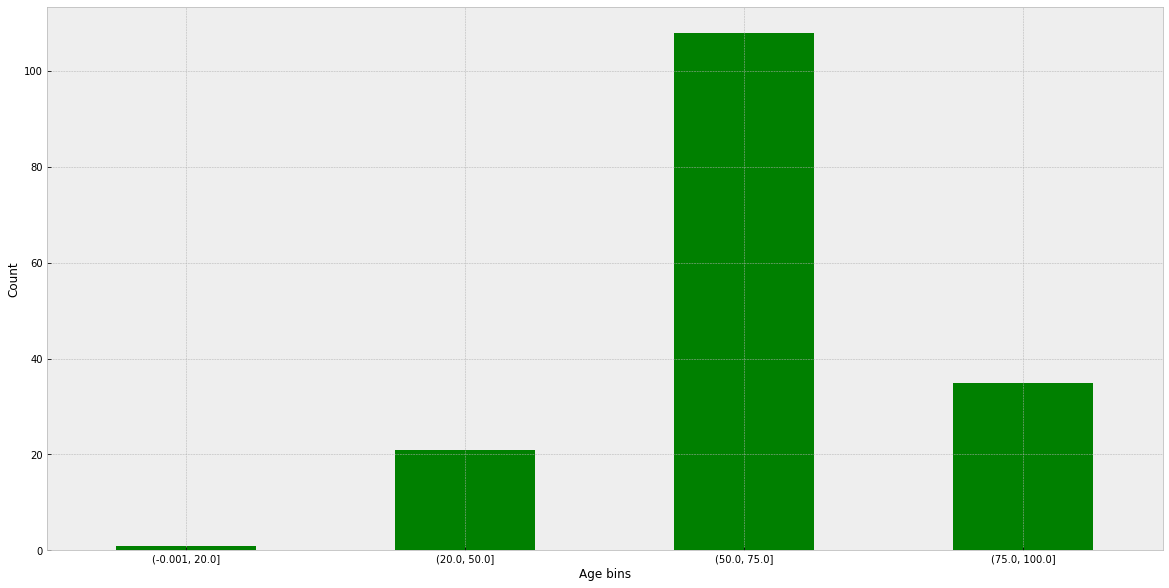

In [12]:
bins = [0, 20, 50, 75, 100]

out = pd.cut(
    data.age, 
    bins=bins,
    include_lowest=True
)

ax = out.value_counts(sort=False).plot.bar(
    rot=0, 
    color="g", 
    figsize=(20,10)
)

plt.xlabel('Age bins')
plt.ylabel('Count')
plt.show()

The age distribution for survivors and deceased is quite similar. After binning and plots analysis we can see that the largest proportion of survivors/died patients were in age range of 50-75.

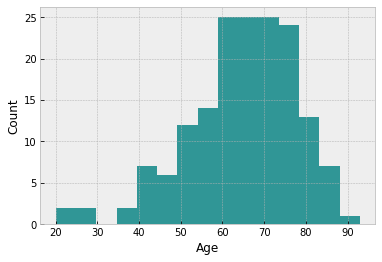

In [13]:
ax = data.age.hist(
    bins=15,
    color='teal', 
    alpha=0.8
)

ax.set(
    xlabel='Age', 
    ylabel='Count'
)

plt.show()

### GRAMS_OF_ALCOHOL_PER_DAY VS CLASS_ATTRIBUTE (SURVIVAL)

In [14]:
data['grams_of_alcohol_per_day'].isnull().sum()

48

In [15]:
max(data["grams_of_alcohol_per_day"])

500.0

In [16]:
min(data["grams_of_alcohol_per_day"])

0.0

In [17]:
data["grams_of_alcohol_per_day"].mean()

71.00854700854701

In [18]:
data["grams_of_alcohol_per_day"].median()

75.0

/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


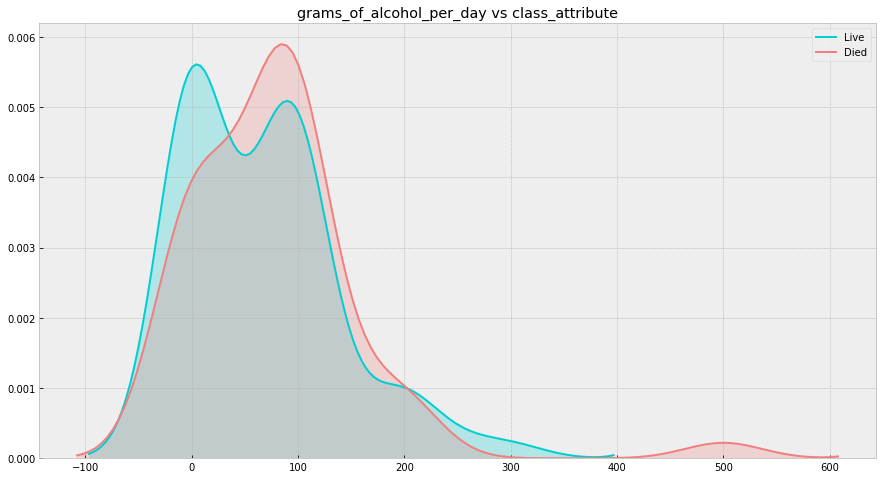

In [19]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data.grams_of_alcohol_per_day[data.class_attribute == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data.grams_of_alcohol_per_day[data.class_attribute == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['Live', 'Died'])
plt.title('grams_of_alcohol_per_day vs class_attribute')
plt.show()

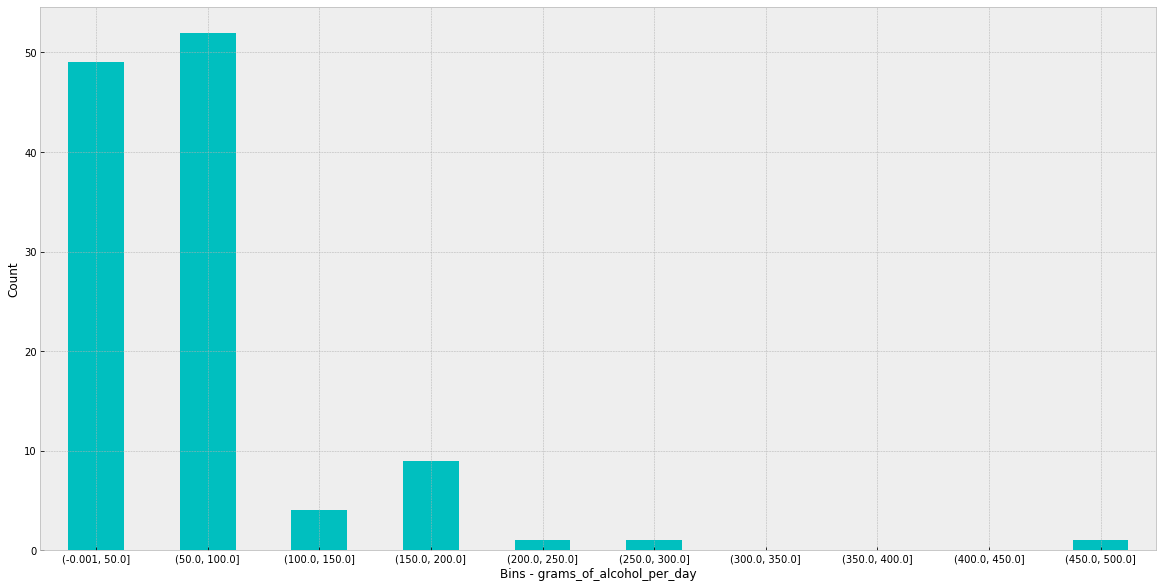

In [20]:
bins = [
    0, 50, 100, 
    150, 200, 250, 
    300, 350, 400,
    450, 500
]

out = pd.cut(
    data.grams_of_alcohol_per_day, 
    bins=bins,
    include_lowest=True
)

ax = out.value_counts(sort=False).plot.bar(
    rot=0, 
    color='c', 
    figsize=(20,10)
)

plt.xlabel('Bins - grams_of_alcohol_per_day')
plt.ylabel('Count')
plt.show()

### PACKS_OF_CIGARETS_PER_YEAR VS CLASS_ATTRIBUTE (SURVIVAL)

In [21]:
data['packs_of_cigarets_per_year'].isnull().sum()

53

In [22]:
max(data['packs_of_cigarets_per_year'])

510.0

In [23]:
min(data['packs_of_cigarets_per_year'])

0.0

In [24]:
data['packs_of_cigarets_per_year'].mean()

20.464285714285715

/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


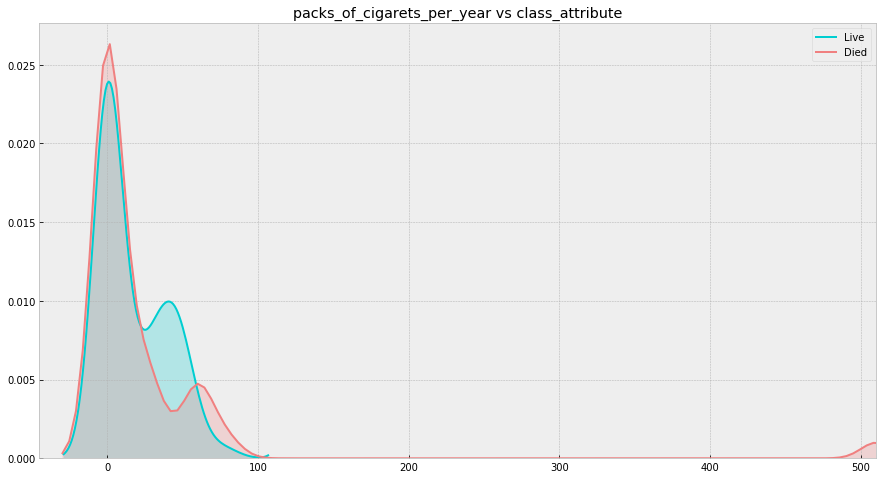

In [25]:
plt.figure(figsize=(15,8))

sns.kdeplot(
    data["packs_of_cigarets_per_year"][data.class_attribute == 1], 
    color="darkturquoise", 
    shade=True
)

sns.kdeplot(
    data["packs_of_cigarets_per_year"][data.class_attribute == 0], 
    color="lightcoral", 
    shade=True
)

plt.legend(['Live', 'Died'])
plt.title('packs_of_cigarets_per_year vs class_attribute')
plt.xlim(-45, 510)
plt.show()

#### What do we know about the survival ?

In [26]:
data['class_attribute'].value_counts()

1    102
0     63
Name: class_attribute, dtype: int64

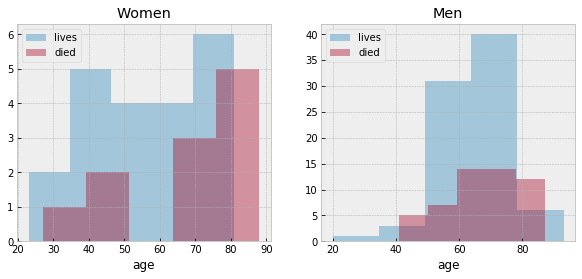

In [27]:
lives = 'lives'
died = 'died'

fig, axes = plt.subplots(
    nrows=1, 
    ncols=2,
    figsize=(10, 4)
)

# 0-women, 1-men
women = data[data['gender'] == 0]
men = data[data['gender'] == 1]

ax = sns.distplot(
    women[women['class_attribute'] == 1].age.dropna(), 
    bins=5, 
    label=lives, 
    ax=axes[0], 
    kde=False
)

ax = sns.distplot(
    women[women['class_attribute'] == 0].age.dropna(),
    bins=5, 
    label=died, 
    ax=axes[0], 
    kde=False
)

ax.legend()
ax.set_title('Women')

ax = sns.distplot(
    men[men['class_attribute'] == 1].age.dropna(), 
    bins=5, 
    label=lives, 
    ax=axes[1], 
    kde=False
)

ax = sns.distplot(
    men[men['class_attribute'] == 0].age.dropna(), 
    bins=5, 
    label = died, 
    ax = axes[1], 
    kde = False
)

ax.legend()
_ = ax.set_title('Men')

We can see that men are more susceptible to die.

In [28]:
data['class_attribute'].isnull().sum()

0

In [29]:
data['gender'].isnull().sum()

0

In [30]:
data.groupby(['gender','class_attribute'])['class_attribute'].count()

gender  class_attribute
0       0                  11
        1                  21
1       0                  52
        1                  81
Name: class_attribute, dtype: int64

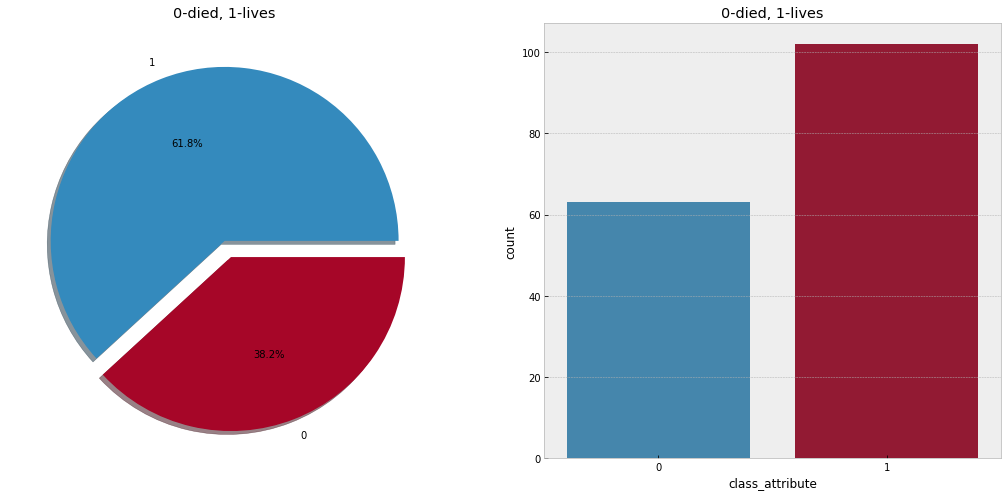

In [31]:
f, ax=plt.subplots(
    1,
    2,
    figsize=(18,8)
)

data['class_attribute'].value_counts().plot.pie(
    explode=[0,0.1],
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)

ax[0].set_title('0-died, 1-lives')
ax[0].set_ylabel('')

sns.countplot(
    'class_attribute',
    data=data,ax=ax[1]
)

ax[1].set_title('0-died, 1-lives')

plt.show()

### MISSING VALUES

In [32]:
total_missing_data = data.isnull().sum().sort_values(ascending=False)

percent_of_missing_data = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
    [
        total_missing_data, 
        percent_of_missing_data
    ], 
    axis=1, 
    keys=['Total', 'Percent']
)

missing_data.head(15)

,Total,Percent
oxygen_saturation_%,80,0.484848
ferritin,80,0.484848
iron,79,0.478788
packs_of_cigarets_per_year,53,0.321212
esophageal_varices,52,0.315152
grams_of_alcohol_per_day,48,0.290909
direct_bilirubin_mg/dL,44,0.266667
smoking,41,0.248485
hepatitis_b_e_antigen,39,0.236364
endemic_countries,39,0.236364


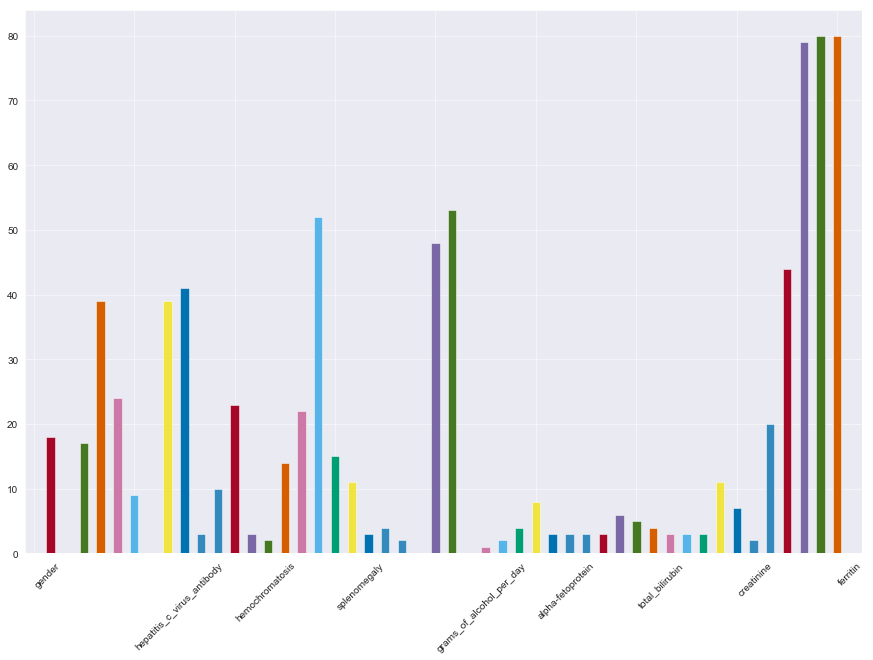

In [33]:
cons = data.loc[:, :]

cons['null_values'] = cons.isnull().sum(axis=1)

null_values = cons.drop('null_values', axis=1).isnull().sum()

sns.set_style("darkgrid")

plt.figure(figsize=(15,10))

pbar = null_values.plot.bar()

plt.xticks(
    list(range(0,len(null_values.index),6)), 
    list(null_values.index[0::6]), 
    rotation=45, 
    ha='left'
)

plt.show()

In [34]:
data.groupby('class_attribute').count()

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,...,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,null_values
class_attribute,,,,,,,,,,,,,,,,,,,,,
0,63,62,63,53,46,50,57,63,48,46,...,63,61,61,63,54,48,39,39,40,63
1,102,85,102,95,80,91,99,102,78,78,...,99,93,97,100,91,73,47,46,45,102


In [35]:
data2 = data.drop(columns=['null_values'])

### HEATMAP WITH NaN

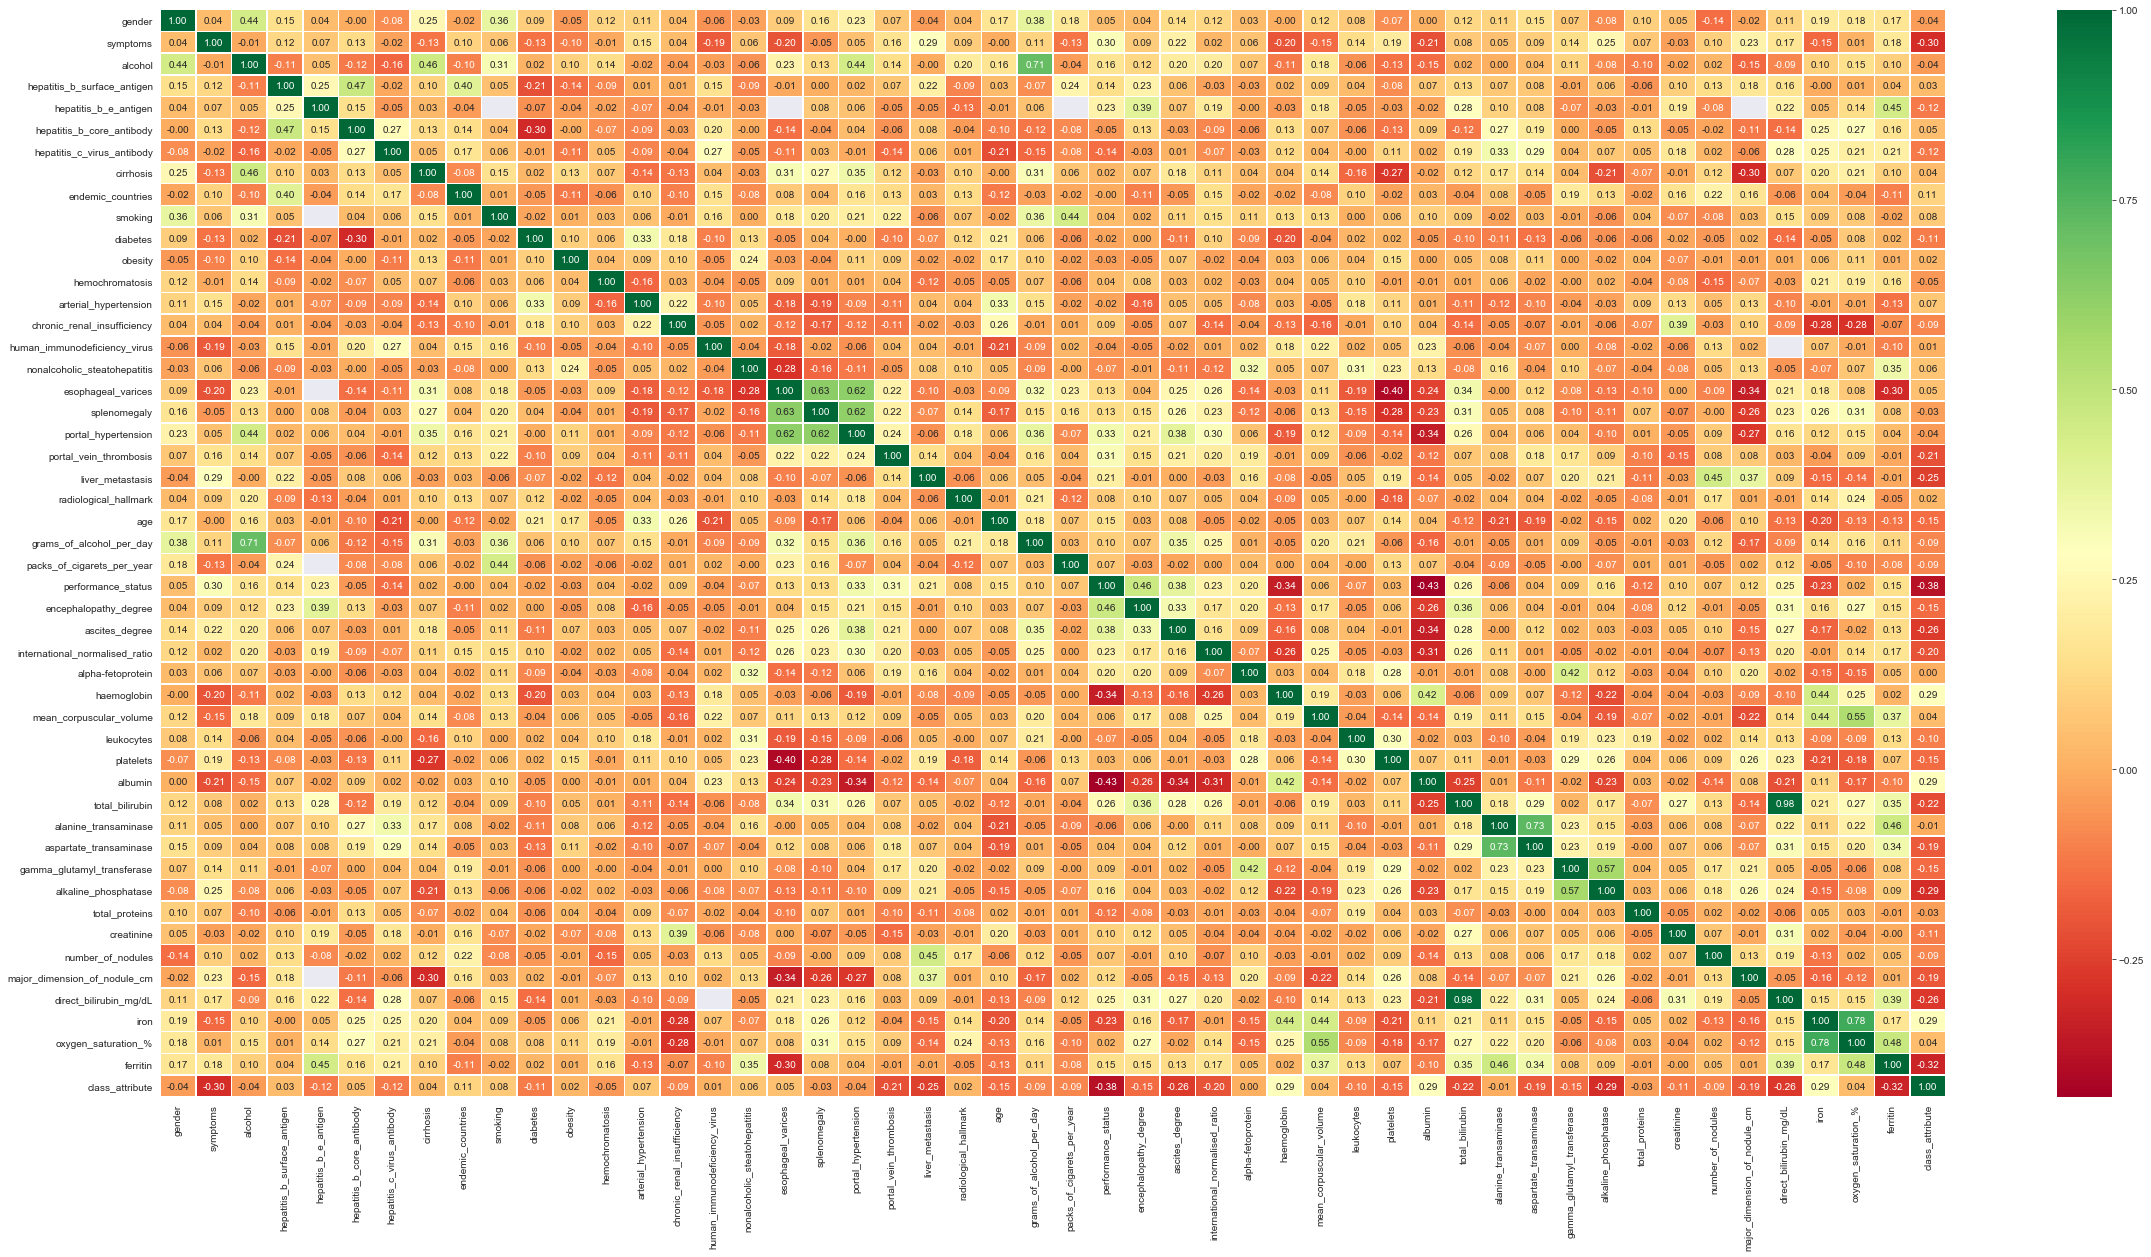

In [36]:
corr = data2.corr()

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()

### WORKING WITH MISSING VALUES

In [37]:
def prepare_missing_values_for_nans(df=None, columns=None):
    """
    Looking for the most frequent value for both decision classes outputs - 0,1.
    """
    
    to_update_nans_dict = {}
    
    if columns:
        for decision_class in [0, 1]:
            for column in columns:
                vals = df[df.class_attribute == decision_class][column].value_counts()
                
                to_update_nans_dict['{decision_class}_{column}'.format(
                    decision_class=decision_class,
                    column=column
                )] = vals.idxmax()
                
        return to_update_nans_dict

In [38]:
def replace_missing_values(df=None, columns=None, to_update_nans_dict=None):
    """
    Replacing NaN with the most frequent values for both decission classes outputs - 0,1.
    """
    
    df_list = []
    
    if columns:
        for decision_class in [0, 1]:
            _df = df[df.class_attribute == decision_class].reset_index(drop=True)

            for column in columns:        
                _df[column] = _df[column].fillna(
                    to_update_nans_dict['{}_{}'.format(decision_class, column)]
            )

            df_list.append(_df)

        return df_list

### NOMINAL VALUES

In [39]:
# replacing NaNs with the most frequent value in column
nominal_indexes = [
    1, 3, 4, 5, 
    6, 8, 9, 10, 
    11, 12, 13, 
    14, 15, 16, 
    17, 18, 19, 
    20, 21, 22
]

nominal_columns_to_discretize = list(itemgetter(*nominal_indexes)(columns))

In [40]:
# prepare missing values
nominal_dict = prepare_missing_values_for_nans(
    df=data2, 
    columns=nominal_columns_to_discretize
)

# replace NaN
missing_nominal_values_list = replace_missing_values(
    df=data2,
    columns=nominal_columns_to_discretize,
    to_update_nans_dict=nominal_dict

)

# data2[nominal_columns_to_discretize] = data2[nominal_columns_to_discretize].apply(
#     lambda x:x.fillna(x.value_counts().index[0])
# )

In [41]:
data2 = pd.concat(missing_nominal_values_list).reset_index(drop=True)

### CONTINUOUS VALUES

In [42]:
# KNN imputation
# Nearest neighbor imputations which weights samples 
# using the mean squared difference on features 
# for which two rows both have observed data.
continuous_indexes = [
    24,25,29,30,
    31,32,33,34,
    35,36,37,38,
    39,40,41,42,
    44,45,46,47,
    48]


continuous_columns_to_discretize = list(
    itemgetter(*continuous_indexes)(columns)
)

continuous_data = data2[continuous_columns_to_discretize].as_matrix()

/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [43]:
# method 1 - KNN neighbours
X_filled_knn = KNN(k=3).complete(continuous_data)

data2[continuous_columns_to_discretize] = X_filled_knn

Imputing row 1/165 with 3 missing, elapsed time: 0.017
Imputing row 101/165 with 0 missing, elapsed time: 0.024


In [44]:
X_filled_knn.shape

(165, 21)

### INTEGER VALUES

In [45]:
integer_columns = ['age', 'number_of_nodules']

# prepare missing integer values
integer_dict = prepare_missing_values_for_nans(
    df=data2, 
    columns=integer_columns
)

In [46]:
integer_dict

{'0_age': 72,
 '0_number_of_nodules': 5.0,
 '1_age': 71,
 '1_number_of_nodules': 1.0}

In [47]:
# replace NaN
missing_integer_values_list = replace_missing_values(
    df=data2,
    columns=integer_columns,
    to_update_nans_dict=integer_dict

)

In [48]:
data2 = pd.concat(missing_integer_values_list).reset_index(drop=True)

### ORDINAL VALUES

In [49]:
data2['ascites_degree'].value_counts()

1.0    109
2.0     36
3.0     18
Name: ascites_degree, dtype: int64

In [50]:
ordinal_columns = ['encephalopathy_degree', 'ascites_degree', 'performance_status']

In [51]:
# prepare missing ordinal values
ordinal_dict = prepare_missing_values_for_nans(
    df=data2, 
    columns=ordinal_columns
)

In [52]:
ordinal_dict

{'0_encephalopathy_degree': 1.0,
 '0_ascites_degree': 1.0,
 '0_performance_status': 0,
 '1_encephalopathy_degree': 1.0,
 '1_ascites_degree': 1.0,
 '1_performance_status': 0}

In [53]:
# replace NaN
missing_ordinal_values_list = replace_missing_values(
    df=data2,
    columns=ordinal_columns,
    to_update_nans_dict=ordinal_dict

)

In [54]:
data2 = pd.concat(missing_ordinal_values_list).reset_index(drop=True)

In [55]:
data2[data2.isnull().any(axis=1)]

,gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,...,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule_cm,direct_bilirubin_mg/dL,iron,oxygen_saturation_%,ferritin,class_attribute


### ORDINAL COLUMNS BINARIZING

In [56]:
ordinal_columns

['encephalopathy_degree', 'ascites_degree', 'performance_status']

In [57]:
binarized_data = []

for c in ordinal_columns:
    lb = LabelBinarizer()
    
    lb.fit(data2[c].values)
    
    binarized = lb.transform(data2[c].values)
    binarized_data.append(binarized)

In [58]:
binarized_ordinal_matrix_data = np.hstack(binarized_data)

In [59]:
binarized_ordinal_matrix_data

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

### BINARIZING number_of_nodules

In [60]:
list(set(data2.number_of_nodules.values))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [61]:
lb = LabelBinarizer()

lb.fit(data2.number_of_nodules.values)

binarized_number_of_nodules = lb.transform(data2.number_of_nodules.values)

### AGE AVERAGING

In [62]:
data2['age_'] = data2.age.apply(lambda x: x / data2.age.max())

In [63]:
data2['age_'].head(10)

0    0.827957
1    0.806452
2    0.526882
3    0.655914
4    0.440860
5    0.774194
6    0.806452
7    0.709677
8    0.688172
9    0.903226
Name: age_, dtype: float64

In [64]:
age_ = data2.age_.values.reshape(-1,1)

### HEATMAP AFTER IMPUTATION

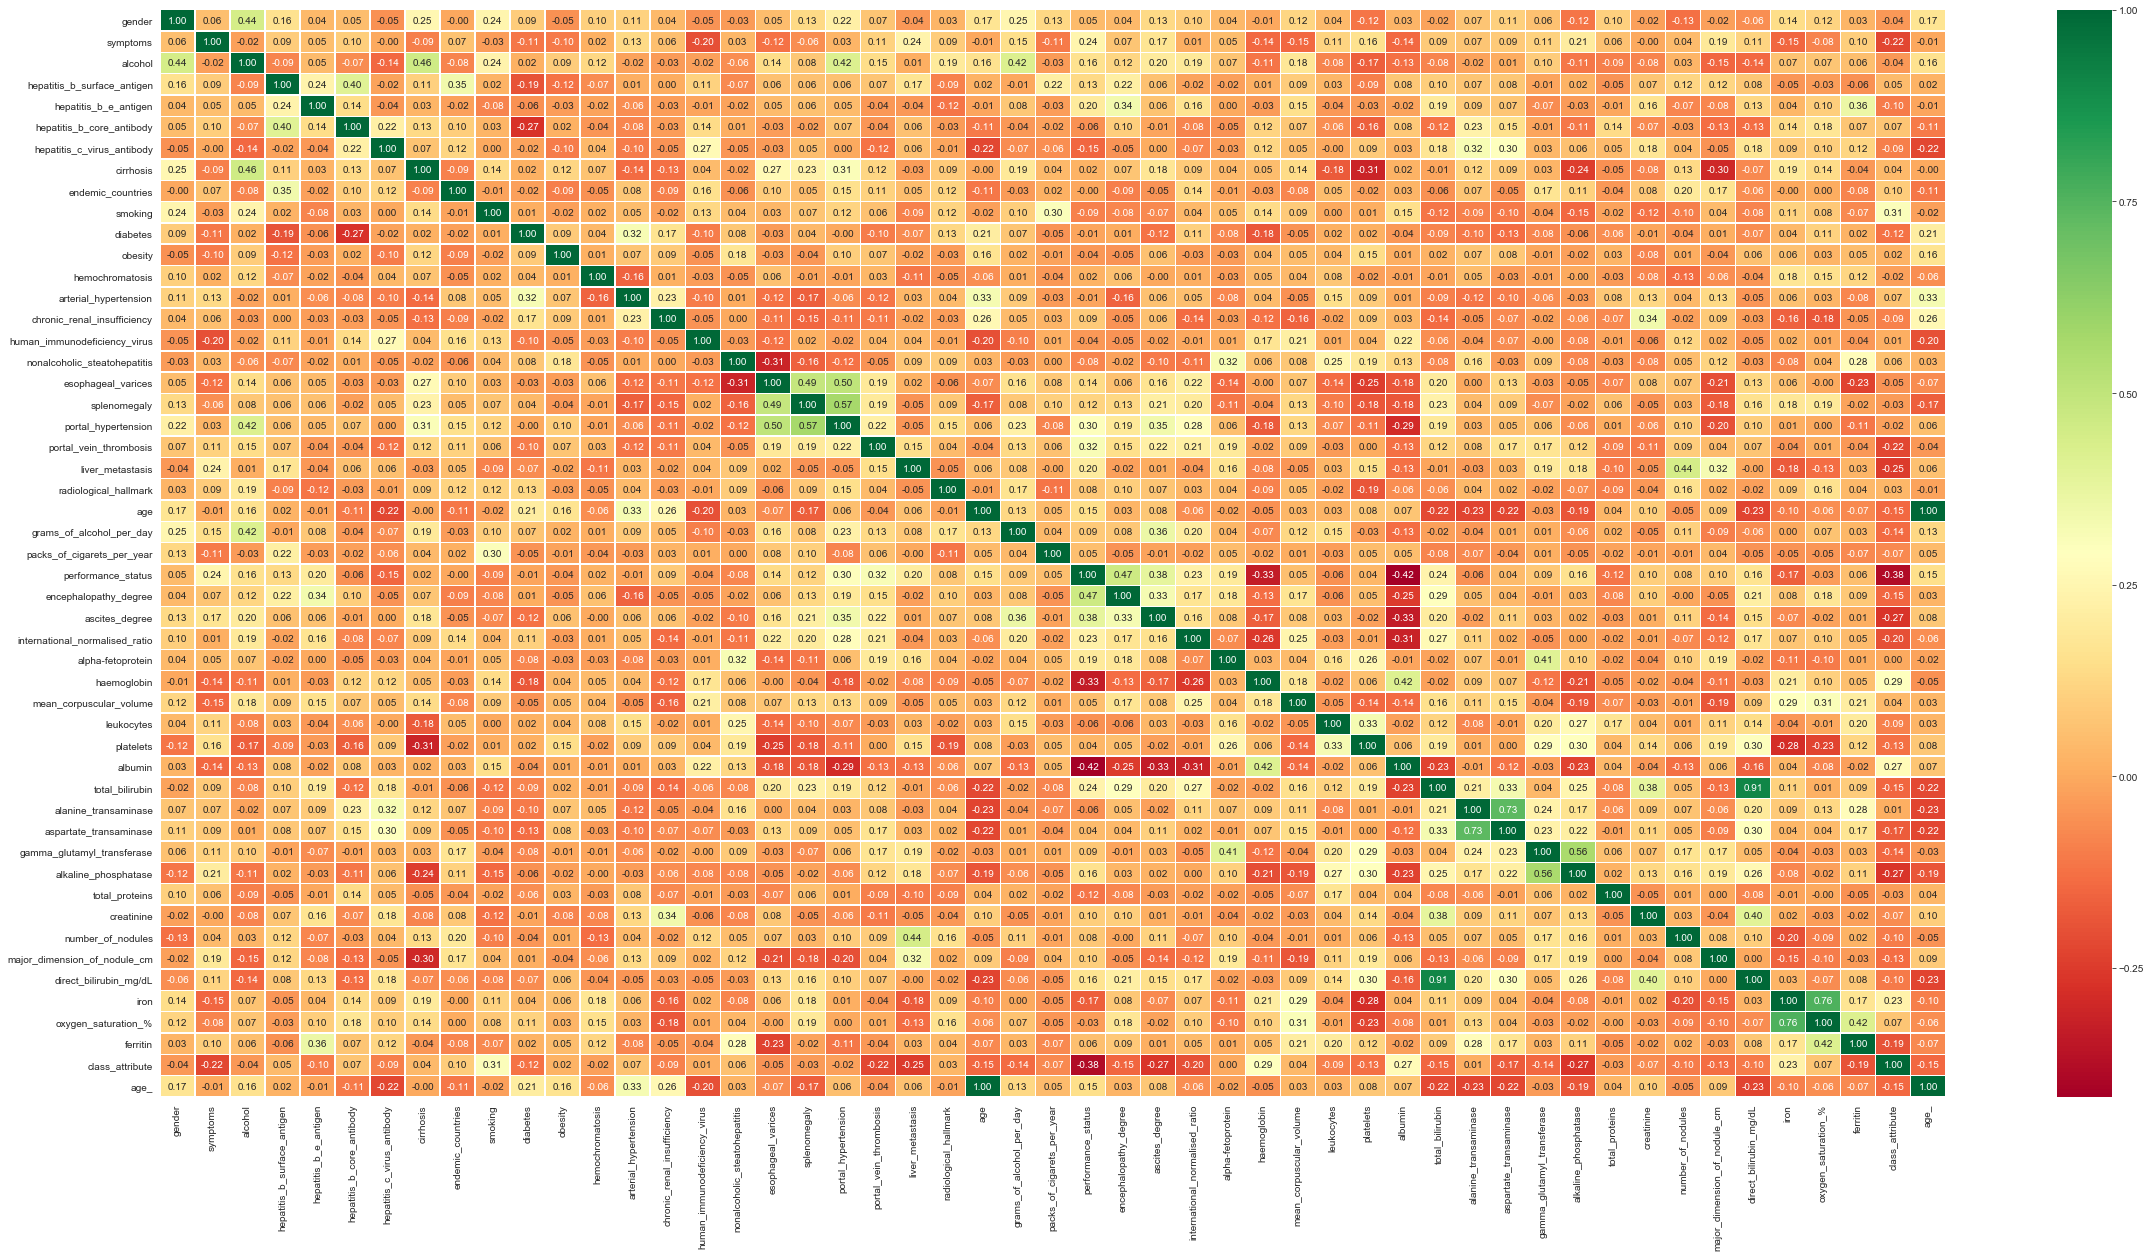

In [65]:
corr = data2.corr()

sns.heatmap(
    data=corr,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    cmap='RdYlGn',
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values
)

fig = plt.gcf()
fig.set_size_inches(40, 20)

plt.show()

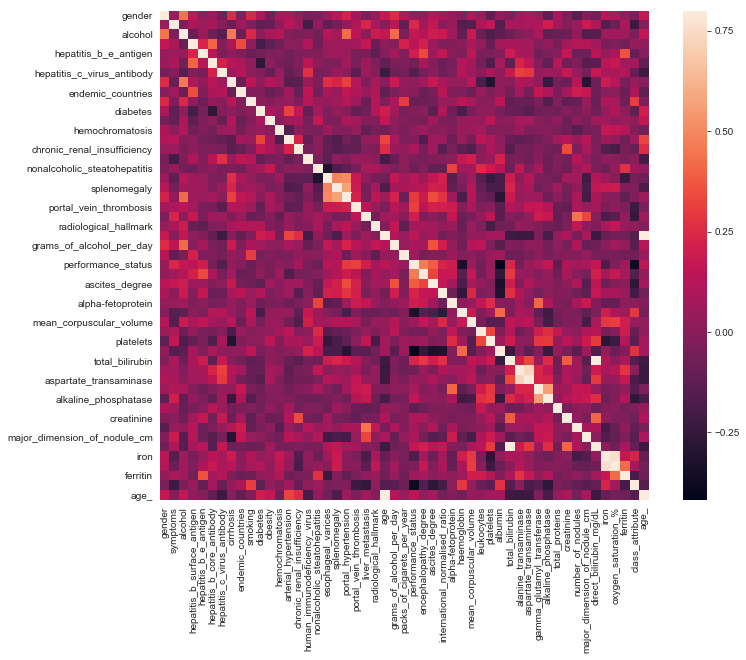

In [66]:
f, ax = plt.subplots(
    figsize=(12, 9)
)

sns.heatmap(
    data2.corr(), 
    vmax=.8, 
    square=True
)

### SPLITTING DATA

We have binarized ordinal values so we don't want to include its initial form to our X dataset.
Also the age column values have been averaged.

In [67]:
to_drop_columns = [
    'age', 
    'encephalopathy_degree', 
    'ascites_degree', 
    'performance_status', 
    'number_of_nodules'
]

columns_set = set(columns)

_columns = list(columns_set.difference(to_drop_columns))

In [68]:
len(columns)

50

In [69]:
len(_columns)

45

In [70]:
X = data2[_columns].as_matrix()
y = data2.class_attribute.values

/Users/miodeq/Desktop/Projects/Pystok33/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [71]:
X_new = np.hstack((X, binarized_ordinal_matrix_data, age_, binarized_number_of_nodules))

In [72]:
X_new.shape

(165, 63)

### STANDARIZATION - OPTIONAL

In [73]:
std_scaler = StandardScaler() #StandardScaler() # RobustScaler
X_new = std_scaler.fit_transform(X_new)

### SPLITTING DATA INTO TRAIN AND TEST DATASETS

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new,
    y,
    random_state=42,
    test_size=0.20
)

### LOGISTIC REGRESSION

In [75]:
log_reg = LogisticRegression(
    solver='lbfgs',
    random_state=42,
    C=0.1,
    multi_class='ovr',
    penalty='l2',
)

In [76]:
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [77]:
log_reg_predict = log_reg.predict(X_test)

In [78]:
log_reg.score(X_test, y_test)

0.9696969696969697

In [79]:
preds = log_reg.predict(X_test)

In [80]:
print('\nLogistic Regression Accuracy: {:.2f}%'.format(accuracy_score(y_test, log_reg_predict) * 100))
print('Logistic Regression AUC: {:.2f}%'.format(roc_auc_score(y_test, log_reg_predict) * 100))
print('Logistic Regression Classification report:\n\n', classification_report(y_test, log_reg_predict))


Logistic Regression Accuracy: 96.97%
Logistic Regression AUC: 97.37%
Logistic Regression Classification report:

              precision    recall  f1-score   support

          0       0.93      1.00      0.97        14
          1       1.00      0.95      0.97        19

avg / total       0.97      0.97      0.97        33



### F1 SCORE AFTER 5-FOLD CROSS-VALIDATION

Walidacja krzyżowa dzieli próbę na kilka podprób (krotności). Następnie generowane są modele najbliższego sąsiedztwa,
wyłączając kolejno dane z każdej podpróby. Pierwszy model jest oparty na wszystkich obserwacjach z wyjątkiem 
tych w pierwszej krotności próby; drugi model jest oparty na wszystkich obserwacjach z wyjątkiem drugiej krotności 
próby itd. 

Dla każdego modelu szacowany jest błąd z zastosowaniem modelu na podpróbie wyłączonej podczas generowania 
modelu. „Najlepsza” liczba obserwacji najbliższego sąsiedztwa to ta, która powoduje najniższy błąd we wszystkich 
krotnościach.

In [81]:
kfold = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
)

predicted = cross_val_predict(
    log_reg, 
    X_new, 
    y, 
    cv=kfold
)

scores = cross_val_score(
    log_reg, 
    X_new, 
    y, 
    cv=kfold,
    scoring='f1'
)

print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("LogisticRegression: F1 after 5-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [0.97674419 0.97560976 1.         0.97435897 1.        ]

             precision    recall  f1-score   support

          0       0.97      0.98      0.98        63
          1       0.99      0.98      0.99       102

avg / total       0.98      0.98      0.98       165

LogisticRegression: F1 after 5-fold cross-validation: 98.53% (+/- 0.02%)


### RANDOM FOREST CLASSIFIER

In [82]:
rf = RandomForestClassifier(
    bootstrap=True,
    criterion='gini',
    n_estimators=45,
    random_state=42,
    n_jobs=-1, 
    oob_score = True, 
    max_depth=5, 
    max_features='sqrt', 
    min_samples_leaf=1,
    min_samples_split=2
)

In [83]:
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

In [84]:
print('\nRandomForestClassifier Accuracy: {:.2f}%'.format(accuracy_score(y_test, rf_predict) * 100))
print('RandomForestClassifier AUC: {:.2f}%'.format(roc_auc_score(y_test, rf_predict) * 100))
print('RandomForestClassifier Classification report:\n\n', classification_report(y_test, rf_predict))


RandomForestClassifier Accuracy: 96.97%
RandomForestClassifier AUC: 96.43%
RandomForestClassifier Classification report:

              precision    recall  f1-score   support

          0       1.00      0.93      0.96        14
          1       0.95      1.00      0.97        19

avg / total       0.97      0.97      0.97        33



In [85]:
strat_k_fold = StratifiedKFold(
    n_splits=10,
    random_state=42,
)

rfecv = RFECV(
    estimator=rf,
    cv=strat_k_fold,
    scoring='f1'
)

rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
   n_jobs=1, scoring='f1', step=1, verbose=0)

In [86]:
predicted = cross_val_predict(
    rf, 
    X_new, 
    y, 
    cv=strat_k_fold
)

In [87]:
scores = cross_val_score(
    rf, 
    X_new, 
    y, 
    cv=strat_k_fold,
    scoring='f1'
)

In [88]:
print('Cross-validated scores: {}\n'.format(scores))

print(classification_report(y, predicted))

print("RandomForestClassifier: F1 after 10-fold cross-validation: {:.2f}% (+/- {:.2f}%)".format(
    scores.mean() * 100,
    scores.std() * 2
))

Cross-validated scores: [1.         1.         1.         0.95238095 0.95238095 1.
 1.         1.         0.95238095 1.        ]

             precision    recall  f1-score   support

          0       1.00      0.95      0.98        63
          1       0.97      1.00      0.99       102

avg / total       0.98      0.98      0.98       165

RandomForestClassifier: F1 after 10-fold cross-validation: 98.57% (+/- 0.04%)
